In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import chainer
 
start = dt.date(2011,1,1)
end = dt.date(2018,7,16)

#AMZN:Amazon、AAPL:Apple、GOOGL:Google、ACN:ｱｸｾﾝﾁｭｱ、
#AFL:ｱﾌﾗｯｸ、DIS:ﾃﾞｨｽﾞﾆｰ、FB:Facebook、NVDA:NVIDIA
df_org= web.DataReader('NVDA',"morningstar",start,end)

#翌日のOpen値入力
df_add = df_org['Open'].shift(-1)
#最終日は当日のOpen値入力(これしないとNANになる)
df_add[len(df_org)-1] = df_add[len(df_org)-2] 

#翌日のOpen値入力
df_org = pd.concat([df_org,df_add], axis=1)

#ｶﾗﾑ更新
df_org.columns = ['Close', 'High','Low', 'Open', 'Volume','Open-1']

df_org.tail(10)

Exception: Request Error!: 404 : Not Found

In [2]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler(feature_range=(0, 1))
x2_scaler = MinMaxScaler(feature_range=(0, 1))
x3_scaler = MinMaxScaler(feature_range=(0, 1))
t_scaler = MinMaxScaler(feature_range=(0, 1))
df_x = x_scaler.fit_transform(np.array(df_org['Open']).reshape(-1,1)).astype(np.float32)
df_x2 = x2_scaler.fit_transform(np.array(df_org['Close']).reshape(-1,1)).astype(np.float32)
df_x3 = x3_scaler.fit_transform(np.array(df_org['High']).reshape(-1,1)).astype(np.float32)
df_t = t_scaler.fit_transform(np.array(df_org['Close']).reshape(-1,1)).astype(np.float32)


In [3]:
#訓練データと教師データへの分割

x,x2,x3,t = [],[],[],[]
 
N = len(df_org)
M = 30
for n in range(M,N):
    _x = df_x[n-M:n]
    _x2 = df_x2[n-M:n]
    _x3 = df_x3[n-M:n]
    _t = df_t[n]
    x.append(_x)
    x2.append(_x2)
    x3.append(_x3)
    t.append(_t)

#trainﾃﾞｰﾀの割合
ratio_train_test = 0.8
#testﾃﾞｰﾀの個数
n_test = 1
#testﾃﾞｰﾀ数を個数で決めるか割合で決めるかのSW
SW = -1

#例：x[1]は初日からM日分の(標準化された)Closeﾃﾞｰﾀ、t[1]はM+1日目のCloseﾃﾞｰﾀ
x = np.array(x, dtype = np.float32)
x2 = np.array(x2, dtype = np.float32)
x3 = np.array(x3, dtype = np.float32)
t = np.array(t, dtype = np.float32).reshape(len(t),1)

x = np.c_[x,x2]

print(x)

if SW == 1:
    n_train = int(len(x) * ratio_train_test)
elif SW == -1:
    n_train = len(x)-n_test
else:
    pass

dataset = list(zip(x, t))
train, test = chainer.datasets.split_dataset(dataset,n_train)

[[[ 0.01589681  0.01737565]
  [ 0.01719853  0.01717998]
  [ 0.01779022  0.02191523]
  ..., 
  [ 0.04926827  0.04660901]
  [ 0.04457418  0.04476969]
  [ 0.04425861  0.04731343]]

 [[ 0.01719853  0.01717998]
  [ 0.01779022  0.02191523]
  [ 0.02331269  0.03111181]
  ..., 
  [ 0.04457418  0.04476969]
  [ 0.04425861  0.04731343]
  [ 0.04836101  0.04590459]]

 [[ 0.01779022  0.02191523]
  [ 0.02331269  0.03111181]
  [ 0.03001854  0.03322506]
  ..., 
  [ 0.04425861  0.04731343]
  [ 0.04836101  0.04590459]
  [ 0.04595479  0.04371307]]

 ..., 
 [[ 0.94753659  0.94239426]
  [ 0.95660919  0.96364421]
  [ 0.97633231  0.99193835]
  ..., 
  [ 0.94213128  0.93088871]
  [ 0.93984461  0.9465425 ]
  [ 0.93885845  0.92415762]]

 [[ 0.95660919  0.96364421]
  [ 0.97633231  0.99193835]
  [ 0.99992108  0.99279928]
  ..., 
  [ 0.93984461  0.9465425 ]
  [ 0.93885845  0.92415762]
  [ 0.93830615  0.93863732]]

 [[ 0.97633231  0.99193835]
  [ 0.99992108  0.99279928]
  [ 0.98591769  0.99311233]
  ..., 
  [ 0.93885

In [4]:
# chainerと必要なパッケージをインポート
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions
import chainer.cuda

# ニューラルネットワークモデルを作成
class RNN(Chain):
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units)
            self.l2 = L.Linear(None, n_output)
        
    def reset_state(self):
        self.l1.reset_state()

        
    def __call__(self, x, t):
        y = self.predict(x)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss},self)
        return loss
        
    def predict(self, x):
        #if train:
            #h1 = F.dropout(self.l1(x),ratio = 0.5)
        #else:
        h1 = self.l1(x)
        return self.l2(h1)

## LSTMUpdaterを作る。
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater,self).__init__(data_iter, optimizer, device=None)
        self.device = device
        
    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")
        
        batch = data_iter.__next__()
        x_batch, t_batch = chainer.dataset.concat_examples(batch, self.device)
        
        optimizer.target.reset_state()           #追加
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, t_batch)
        loss.backward()
        loss.unchain_backward()                  #追記
        optimizer.update() 

print("step done")

step done


In [5]:
# 乱数のシードを固定 (再現性の確保)
np.random.seed(1)
 
# モデルの宣言
model = RNN(30, 1)
 
# GPU対応
#chainer.cuda.get_device(0).use()
#model.to_gpu()                 
 
# Optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)
 
# Iterator
batchsize = 20 #ﾐﾆﾊﾞｯﾁのｻｲｽﾞ
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
 
# Updater &lt;- LSTM用にカスタマイズ
updater = LSTMUpdater(train_iter, optimizer,device = -1)
 
# Trainerとそのextensions
epoch = 5
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
 
# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model,device = -1))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
 
# １エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

print("step done")

step done


In [6]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           0.00742126  0.000297606           0.367167      
2           0.000465481  0.000213509           0.627084      
3           0.000425312  0.000205668           0.898545      
4           0.000377783  0.00328753            1.153         
5           0.00035473  0.0233341             1.48782       


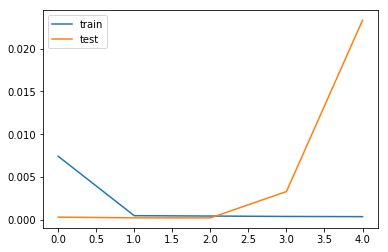

In [7]:
# 結果を読み込み
import json
with open('result/log') as f:
     logs = json.load(f)
 
# 結果を整理
loss_train = [ log['main/loss'] for log in logs ]
loss_test  = [ log['validation/main/loss'] for log in logs ]
 
# プロット
plt.plot(loss_train, label='train')
plt.plot(loss_test,  label='test')
plt.legend()
plt.show()

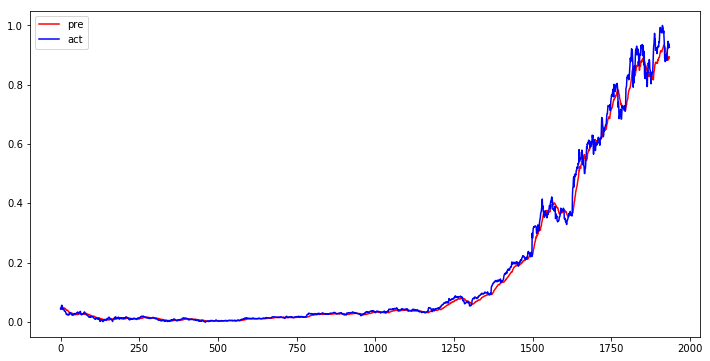

In [8]:
# 訓練：90%, 検証：10%で分割する
if SW == 1:
    n_train = int(len(x) * ratio_train_test)
elif SW == -1:
    n_train = len(x)-n_test
else:
    pass


train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

# 訓練データ
model.reset_state()
train_y = model.predict(Variable(train_x)).data# 訓練：90%, 検証：10%でランダムに分割する

n_train = int(len(x) * 1)
train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

# プロット
plt.figure(figsize=(12,6))
 
plt.plot(train_y,label = 'pre', color='red')   # 予測値
plt.plot(train_t, label = 'act', color='blue')  # 実測値
plt.legend()
plt.show()

[[[ 0.99992108  0.99279928]
  [ 0.98591769  0.99311233]
  [ 1.          0.98430711]
  [ 0.98011911  0.98188078]
  [ 0.98725891  0.97538447]
  [ 0.9869433   0.98305482]
  [ 0.99069071  0.98235041]
  [ 0.99692321  1.        ]
  [ 0.99842215  0.99354285]
  [ 0.99400419  0.99287754]
  [ 0.98390597  0.97362345]
  [ 0.98750347  0.98199821]
  [ 0.99447751  0.96164834]
  [ 0.97219044  0.9375416 ]
  [ 0.92761624  0.89124566]
  [ 0.91597962  0.9024772 ]
  [ 0.91617686  0.87793994]
  [ 0.88292372  0.89805502]
  [ 0.9151513   0.88255781]
  [ 0.87807184  0.90345556]
  [ 0.91574299  0.88232303]
  [ 0.88891959  0.88232303]
  [ 0.89771605  0.90537316]
  [ 0.90824819  0.92337495]
  [ 0.94213128  0.93088871]
  [ 0.93984461  0.9465425 ]
  [ 0.93885845  0.92415762]
  [ 0.93830615  0.93863732]
  [ 0.94864106  0.93116266]
  [ 0.93373042  0.92677963]]]
[[[ 0.97633231  0.99193835]
  [ 0.99992108  0.99279928]
  [ 0.98591769  0.99311233]
  [ 1.          0.98430711]
  [ 0.98011911  0.98188078]
  [ 0.98725891  0.

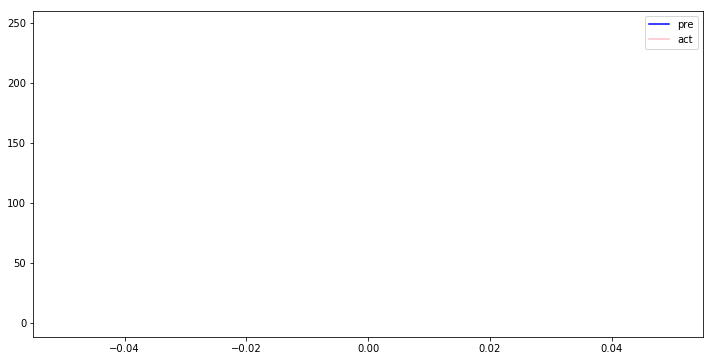

ZeroDivisionError: division by zero

In [9]:

x_,x2_,x3_ = [],[],[]

_x = df_x[N-M:N]
_x2 = df_x2[N-M:N]
_x3 = df_x3[N-M:N]

x_.append(_x)
x2_.append(_x2)
x3_.append(_x3)

#例：x[1]は初日からM日分の(標準化された)Closeﾃﾞｰﾀ、t[1]はM+1日目のCloseﾃﾞｰﾀ
x_ = np.array(x_, dtype = np.float32)
x2_ = np.array(x2_, dtype = np.float32)
x3_ = np.array(x3_, dtype = np.float32)

x_ = np.c_[x_,x2_]

if SW == 1:
    n_train = int(len(x) * ratio_train_test)
elif SW == -1:
    n_train = len(x)-n_test
else:
    pass

train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

print(x_)
print(test_x)

# 検証データ
model.reset_state()
test_y = model.predict(Variable(x_)).data
#test_y = model.predict(Variable(x)).data

test_t = t_scaler.inverse_transform(test_t)

print(test_t)

#予測値の移動平均を計算
num = 5
b = np.ones(num)/num
ave_test_y=np.convolve(test_y[:,0], b, mode='same')
    
# プロット
plt.figure(figsize=(12,6))
 
plt.plot(test_y,label = 'pre', color='blue')   # 予測値
plt.plot(test_t,label = 'act', color='pink')  # 実測値
#plt.plot(ave_test_y,label = 'pre_ave', color='red') #移動平均予測
plt.legend()
plt.show()

updown_y = []
updown_t =[]
score = 0

for i in range(len(test_t)-1):
    if test_t[i+1]>test_t[i]:
        updown_t.append(1)
    else:
        updown_t.append(-1)
    if test_y[i+1]>test_y[i]:
        updown_y.append(1)
    else:
        updown_y.append(-1)
    
    if updown_t[i] == updown_y[i]:
        score = score + 1
    else:
        pass

score = score/len(updown_t)*100
print('勝率=%.3f％'%score)

In [ ]:
###資産運用SIM

#ﾃｽﾄ期間
Period = len(test_t)

df_open = df['Open'][len(df)-Period:len(df)]
df_close = df['Close'][len(df)-Period:len(df)]

#元金
Fund = 10000 #[ﾄﾞﾙ]
Investment = 0 #投資額/日
stock_num = 0 #購入株数/日
charge = 0 #手数料
ratio_inv = 0.5
Fund_his = []

Fund_his.append(Fund)

#株売買ｼﾐｭﾚｰｼｮﾝ
for i in range(Period-1):
    if updown_y[i] ==1:
        Investment = ratio_inv*Fund
        Fund = Fund - Investment
        stock_num = Investment/df_open[i+1] #Open値
        Fund = Fund + stock_num*df_close[i+1]-charge #Close値
    if updown_y[i] == -1:
        Investment = ratio_inv*Fund
        Fund = Fund + Investment
        stock_num = Investment/df_open[i+1]
        Fund = Fund - stock_num*df_close[i+1]-charge
    Fund_his.append(Fund)

plt.plot(Fund_his,label = 'Fund_history', color='pink')  # 実測値
plt.legend()
plt.show()